In [1]:
from pathlib import Path
from typing import Tuple

import aeolus
import iris.pandas
import iris.plot as iplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from aeolus.const import init_const
from aeolus.io import create_dummy_cube, load_vert_lev
from iris.coords import AuxCoord
from iris.util import new_axis, promote_aux_coord_to_dim_coord

In [2]:
import paths

In [3]:
from prep_camembert_ancil import (
    add_mass_mixing_ratios,
    broadcast_to_3d,
    dataframe_to_cubelist,
    interpolate_mmr_in_height,
    load_init_cond,
    load_socrates_gases,
    make_vert_coord,
    prep_profiles,
)

In [4]:
const = init_const("camembert_k2_18b", directory=paths.const)

In [5]:
omega = 2*np.pi / const.day.data
omega*86400

0.19074636633817807

In [5]:
file_path = "https://raw.githubusercontent.com/projectcuisines/camembert/main/InitialConditions/CAMEMBERT_K2-18b_IC.dat"

In [6]:
df = load_init_cond(file_path)

In [8]:
df = prep_profiles(df, const)
df

,pressure_pa,temperature_k,vmr_co,vmr_co2,vmr_h2o,vmr_ch4,vmr_nh3,vmr_h2,vmr_he,exner,theta_k,height_m
0,3.000000e+06,1072.775300,0.001158,0.000109,0.061439,0.040869,0.000835,0.752984,0.142125,1.000000,1072.775300,0.000000e+00
1,2.818383e+06,1068.993050,0.001313,0.000124,0.061269,0.040699,0.000835,0.751394,0.142436,0.983945,1086.435829,9.356534e+03
2,2.238721e+06,1062.367960,0.001741,0.000167,0.060798,0.040227,0.000835,0.748081,0.143080,0.926943,1146.098208,4.377256e+04
3,1.778279e+06,1055.872140,0.002298,0.000224,0.060184,0.039614,0.000835,0.744633,0.143751,0.873244,1209.138004,7.811719e+04
4,1.412538e+06,1048.718630,0.002962,0.000293,0.059451,0.038881,0.000835,0.740772,0.144514,0.822655,1274.797478,1.123928e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
61,2.818383e+00,289.064279,0.004175,0.000884,0.056763,0.037077,0.000828,0.722407,0.148074,0.027410,10545.906439,1.001005e+06
62,2.238721e+00,288.411722,0.004175,0.000884,0.056763,0.037077,0.000828,0.722407,0.148074,0.025822,11169.148515,1.011456e+06
63,1.778279e+00,287.315708,0.004175,0.000884,0.056763,0.037077,0.000828,0.722407,0.148074,0.024326,11810.932838,1.021896e+06
64,1.412538e+00,284.708221,0.004175,0.000884,0.056763,0.037077,0.000828,0.722407,0.148074,0.022917,12423.458376,1.032308e+06


In [8]:
# plt.plot(df["Temperature_K"], df["Pressure_Pa"])
# # plt.plot(df["Temperature_K"].values[73], df["Pressure_Pa"].values[73], marker="o")

# plt.yscale("log")
# plt.ylim(1e7, 1e1)
# plt.xlim(200, 1450)

### Convert VMR to MMR

In [11]:
s_gases = load_socrates_gases(paths.scripts / "socrates_gases.yaml")

In [12]:
df = add_mass_mixing_ratios(df, s_gases, const)

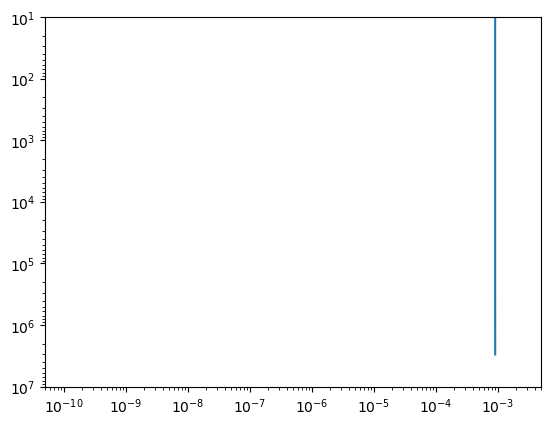

In [13]:
ax = plt.axes()
ax.plot(df["vmr_h2o"].values, df["pressure_pa"].values)
ax.set_ylim(1e7, 10)
ax.set_xlim(5e-11, 5e-3)
ax.set_yscale("log")
ax.set_xscale("log")

In [14]:
df[[i for i in df.columns if i.startswith("mmr_")]].sum(axis=1).max()

0.9961541849208981

### Interpolate in height

In [15]:
# Create the target vertical grid
level_height, model_level_number = make_vert_coord(paths.vert / "Lev_66_4.0e6_uniform")

In [16]:
dset = interpolate_mmr_in_height(
    dataframe_to_cubelist(df),
    target_theta_lev=level_height.points,
)

### Broadcast to 3D

In [17]:
dset_final = broadcast_to_3d(
    dset, level_height=level_height, model_level_number=model_level_number
)

In [20]:
dset_final.extract_strict("h2_mmr")

H2 Mmr (kg kg-1),model_level_number,latitude,longitude
Shape,67,144,192
Dimension coordinates,,,
model_level_number,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
level_height,x,-,-


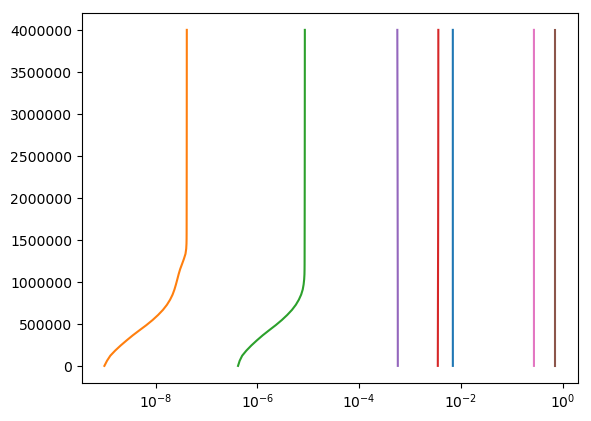

In [21]:
for cube in dset_final:
    iplt.plot(cube[:, 0, 0], cube.coord("level_height"))
plt.xscale("log")

## Approximate the profile with a polynomial

In [14]:
t = df.Temperature_K.values
p = df.Pressure_Pa.values
logp = np.log10(p)

x = np.logspace(-1.5, 7.5, 100)
logx = np.log10(x)

(0.0, 1500.0)

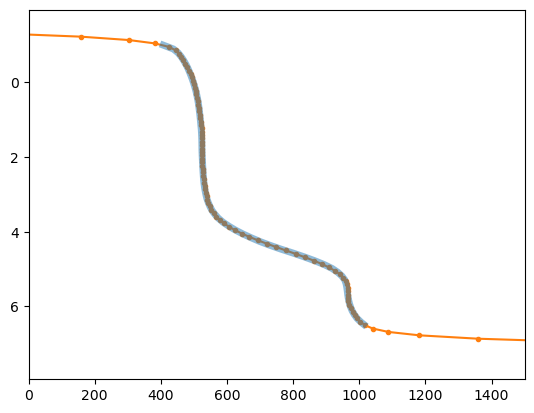

In [15]:
ax = plt.axes()
ax.invert_yaxis()
ax.plot(t, logp, linewidth=5, alpha=0.5, zorder=100)
# for deg in range(4, 11):
deg = 13

coefs = np.polyfit(logp, t, deg)
poly = np.poly1d(coefs)
tt = poly(logx)

ax.plot(tt, logx, marker=".")
ax.set_xlim(0, 1500)

## Forcing terms

In [41]:
pres = np.logspace(7, -2, 100)
p_low = 100
p_high = 1e6

In [42]:
factor = 1 - np.log10(pres / p_low) / np.log10(p_high / p_low)
factor = np.minimum(1, np.maximum(0, factor))
# factor[pres<=p_low] = 1
# factor[pres>=p_high] = 0

(7.5, -3.0)

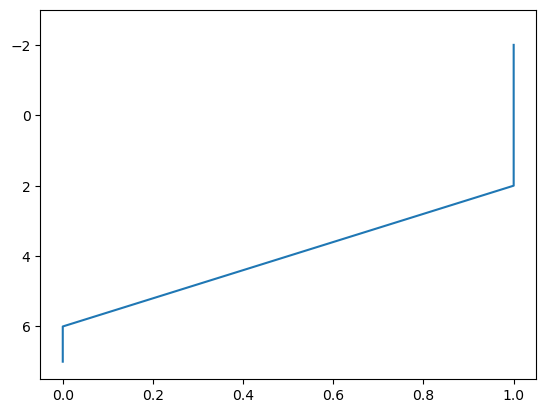

In [43]:
plt.plot(factor, np.log10(pres))
plt.ylim(7.5, -3)

(7.5, -3.0)

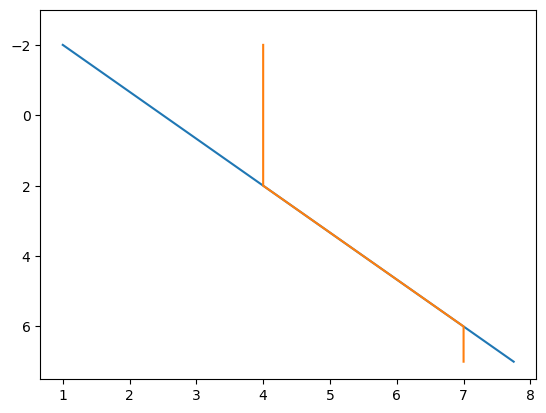

In [44]:
tau = (10**2.5) * (pres**0.75)
tau2 = np.minimum(1e7, np.maximum(1e4, tau))

tau3 = np.copy(tau)
tau3[pres <= 1e2] = 1e4
tau3[pres >= 1e6] = 1e7

plt.plot(np.log10(tau), np.log10(pres))
plt.plot(np.log10(tau2), np.log10(pres))
# plt.plot(np.log10(tau3), np.log10(pres))

plt.ylim(7.5, -3)